# FEMA Disaster Analysis and Prediction Models
This notebook analyzes FEMA disaster data and builds prediction models for disaster assistance amounts
using various machine learning algorithms.

In [1]:
def clean_disaster_length(df):
    df['disasterLength'] = df['disasterLength'].str.split().str[0]
    df['disasterLength'] = pd.to_numeric(df['disasterLength'], errors='coerce')
    return df

In [2]:
import pandas as pd

dates = ['declarationDate','incidentBeginDate','incidentEndDate', 'disasterCloseoutDate']

file = "dataset/preprocessed/FEMA.csv"
df = pd.read_csv(
    file,
    index_col = ['disasterNumber', 'zipCode', 'city'],
    parse_dates = dates,
    low_memory = False
)

file = "dataset/preprocessed/aggregate_FEMA.csv"
agg_df = pd.read_csv(
    file,
    parse_dates = dates,
    index_col = ['disasterNumber'],
    low_memory = False
)

file = "dataset/preprocessed/zipcounts.csv"
zip_df = pd.read_csv(
    file,
    index_col = ['disasterNumber']
)

agg_df = clean_disaster_length(agg_df)
zip_df = clean_disaster_length(zip_df)

# Merge aggregated data
merged_df = agg_df.merge(zip_df[['zip_counts']], left_index=True, right_index=True, how='left')

In [3]:
merged_df.to_csv('dataset/preprocessed/aggregate_FEMA_merged.csv', index = 'disasterNumber')

In [4]:
# Check for missing values
missing_values = merged_df.isna().sum()
print("Missing values in each column:")
print(missing_values)

# View unique incident types
unique_incident_types = merged_df['incidentType'].unique()
print("\nUnique Incident Types:")
print(unique_incident_types)

# Incident Type counts
incident_type_counts = merged_df['incidentType'].value_counts()
print("\nIncident Type Counts:")
print(incident_type_counts)

Missing values in each column:
declarationDate                              0
fyDeclared                                   0
declarationType                              0
incidentType                                 0
declarationTitle                             0
ihProgramDeclared                            0
iaProgramDeclared                            0
paProgramDeclared                            0
hmProgramDeclared                            0
incidentBeginDate                            0
incidentEndDate                              0
disasterCloseoutDate                       298
disasterLength                               0
validRegistrations                           0
averageFemaInspectedDamage                   0
totalInspected                               0
totalDamage                                  0
noFemaInspectedDamage                        0
femaInspectedDamageBetween1And10000          0
femaInspectedDamageBetween10001And20000      0
femaInspectedDamageBetween200

In [5]:
# Combine rare incident types into 'Other'
threshold = 5
incident_counts = merged_df['incidentType'].value_counts()
rare_incidents = incident_counts[incident_counts < threshold].index
merged_df['incidentType'] = merged_df['incidentType'].replace(rare_incidents, 'Other')

# Verify the replacement
print("\nUpdated Incident Type Counts:")
print(merged_df['incidentType'].value_counts())


Updated Incident Type Counts:
incidentType
Severe Storm      272
Hurricane          99
Flood              70
Biological         56
Fire               25
Tornado            22
Other              11
Earthquake          9
Typhoon             9
Tropical Storm      8
Name: count, dtype: int64


In [6]:
# Select relevant features
selected_features = [
    'totalApprovedIhpAmount',
    'approvedForFemaAssistance',
    'totalInspected',
    'zip_counts',
    'totalMaxGrants',
    'incidentType',
    'disasterLength'
]

amt = merged_df[selected_features]

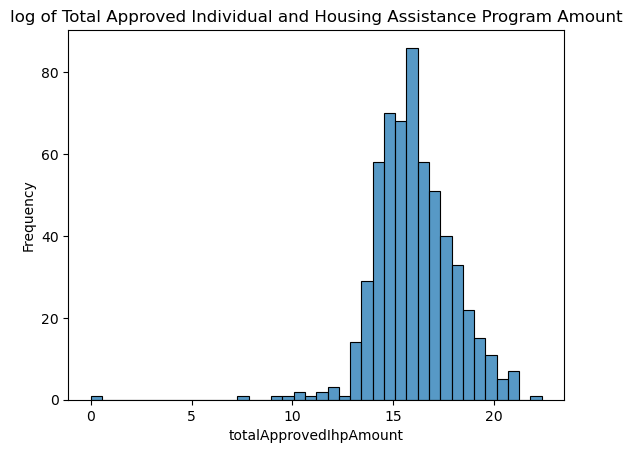

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.histplot(np.log1p(amt['totalApprovedIhpAmount']))
plt.title('log of Total Approved Individual and Housing Assistance Program Amount')
plt.ylabel('Frequency')
plt.show()

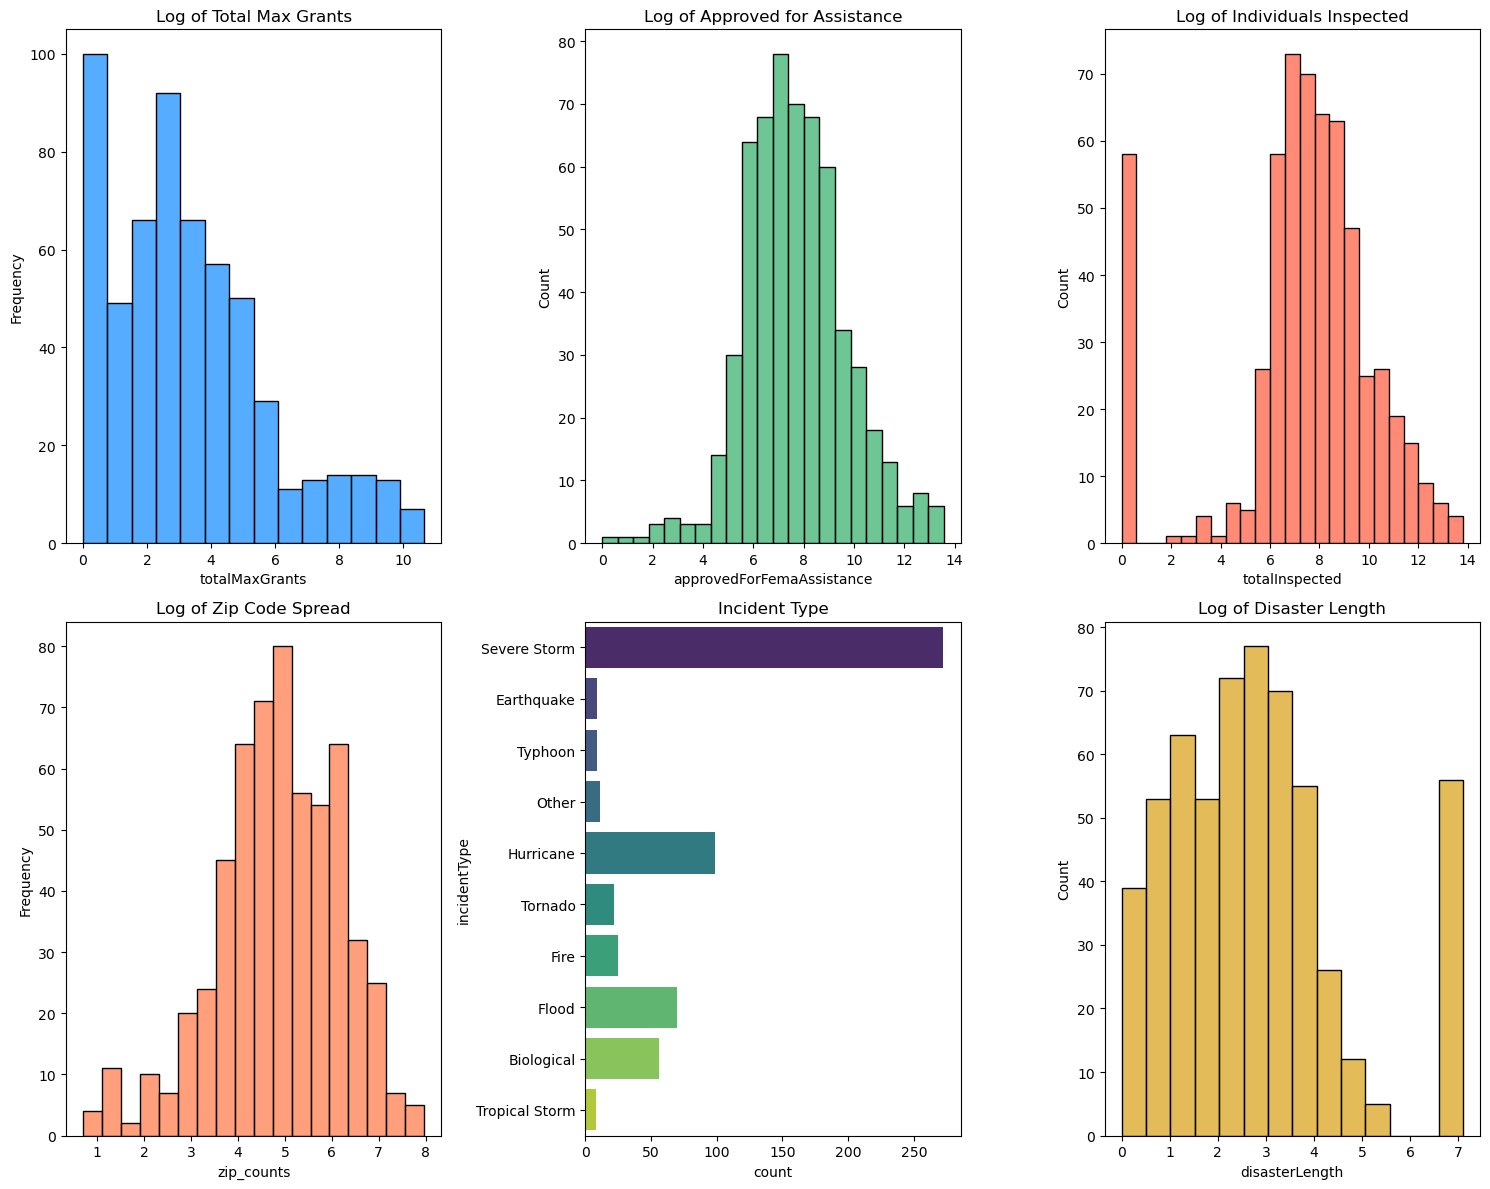

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 12))

plt.subplot(231)
sns.histplot(np.log1p(amt['totalMaxGrants']), color='dodgerblue')
plt.title('Log of Total Max Grants')
plt.ylabel('Frequency')

plt.subplot(232)
sns.histplot(np.log1p(amt['approvedForFemaAssistance']), color='mediumseagreen')
plt.title('Log of Approved for Assistance')

plt.subplot(233)
sns.histplot(np.log1p(amt['totalInspected']), color='tomato')
plt.title('Log of Individuals Inspected')

plt.subplot(234)
sns.histplot(np.log1p(amt['zip_counts']), color='coral')
plt.title('Log of Zip Code Spread')
plt.ylabel('Frequency')

plt.subplot(235)
sns.countplot(y='incidentType', data=amt, hue='incidentType', palette='viridis', legend=False)
plt.title('Incident Type')

plt.subplot(236)
sns.histplot(np.log1p(amt['disasterLength']), color='goldenrod')
plt.title('Log of Disaster Length')

plt.tight_layout()
plt.show()

# Use log-transformation to convert data to normal distribution

In [9]:
logamt = pd.DataFrame()

logamt['IhpAmount'] = np.log1p(amt['totalApprovedIhpAmount'])
logamt['Grants'] = np.log1p(amt['totalMaxGrants'])
logamt['FemaAssistance'] = np.log1p(amt['approvedForFemaAssistance'])
logamt['Inspected'] = np.log1p(amt['totalInspected'])
logamt['Zips'] = np.log1p(amt['zip_counts'])
logamt['Type'] = amt.incidentType
logamt['Length'] = np.log1p(amt['disasterLength'])

logamt.head()

,IhpAmount,Grants,FemaAssistance,Inspected,Zips,Type,Length
disasterNumber,,,,,,,
1439,17.857583,1.609438,9.862978,10.068112,5.771441,Severe Storm,3.135494
1440,13.061281,0.693147,5.609472,5.883322,3.178054,Earthquake,2.079442
1441,14.436943,2.564949,5.993961,6.514713,4.382027,Severe Storm,1.386294
1442,15.008377,2.890372,6.261492,6.620073,4.234107,Severe Storm,2.079442
1443,14.503668,1.609438,6.297109,6.787845,3.044522,Severe Storm,0.693147


In [10]:
logamt = logamt[logamt['IhpAmount'] != 0]

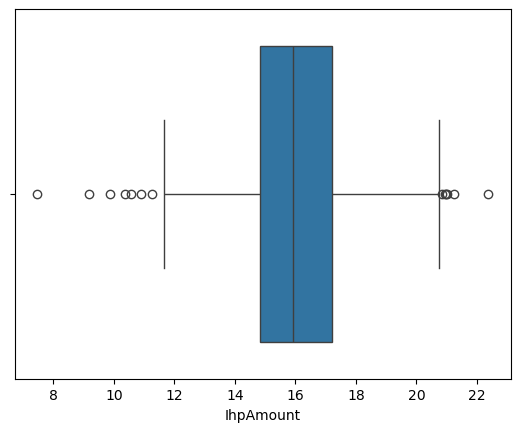

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=logamt['IhpAmount'])
plt.show()

# Limit Outliers effect using winsorize

In [12]:
from scipy.stats.mstats import winsorize

logamt['IhpAmount'] = winsorize(logamt['IhpAmount'], limits=[0.02, 0.02])

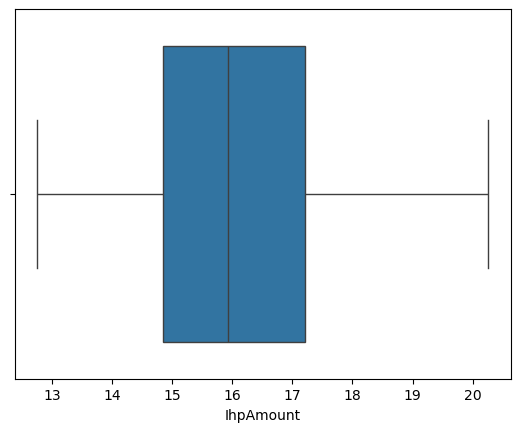

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=logamt['IhpAmount'])
plt.show()

In [14]:
logamt['Grants'] = logamt['Grants'].fillna(logamt['Grants'].mean())
logamt['Inspected'] = logamt['Inspected'].fillna(logamt['Inspected'].mean())
logamt['Length'] = logamt['Length'].fillna(logamt['Length'].mean())

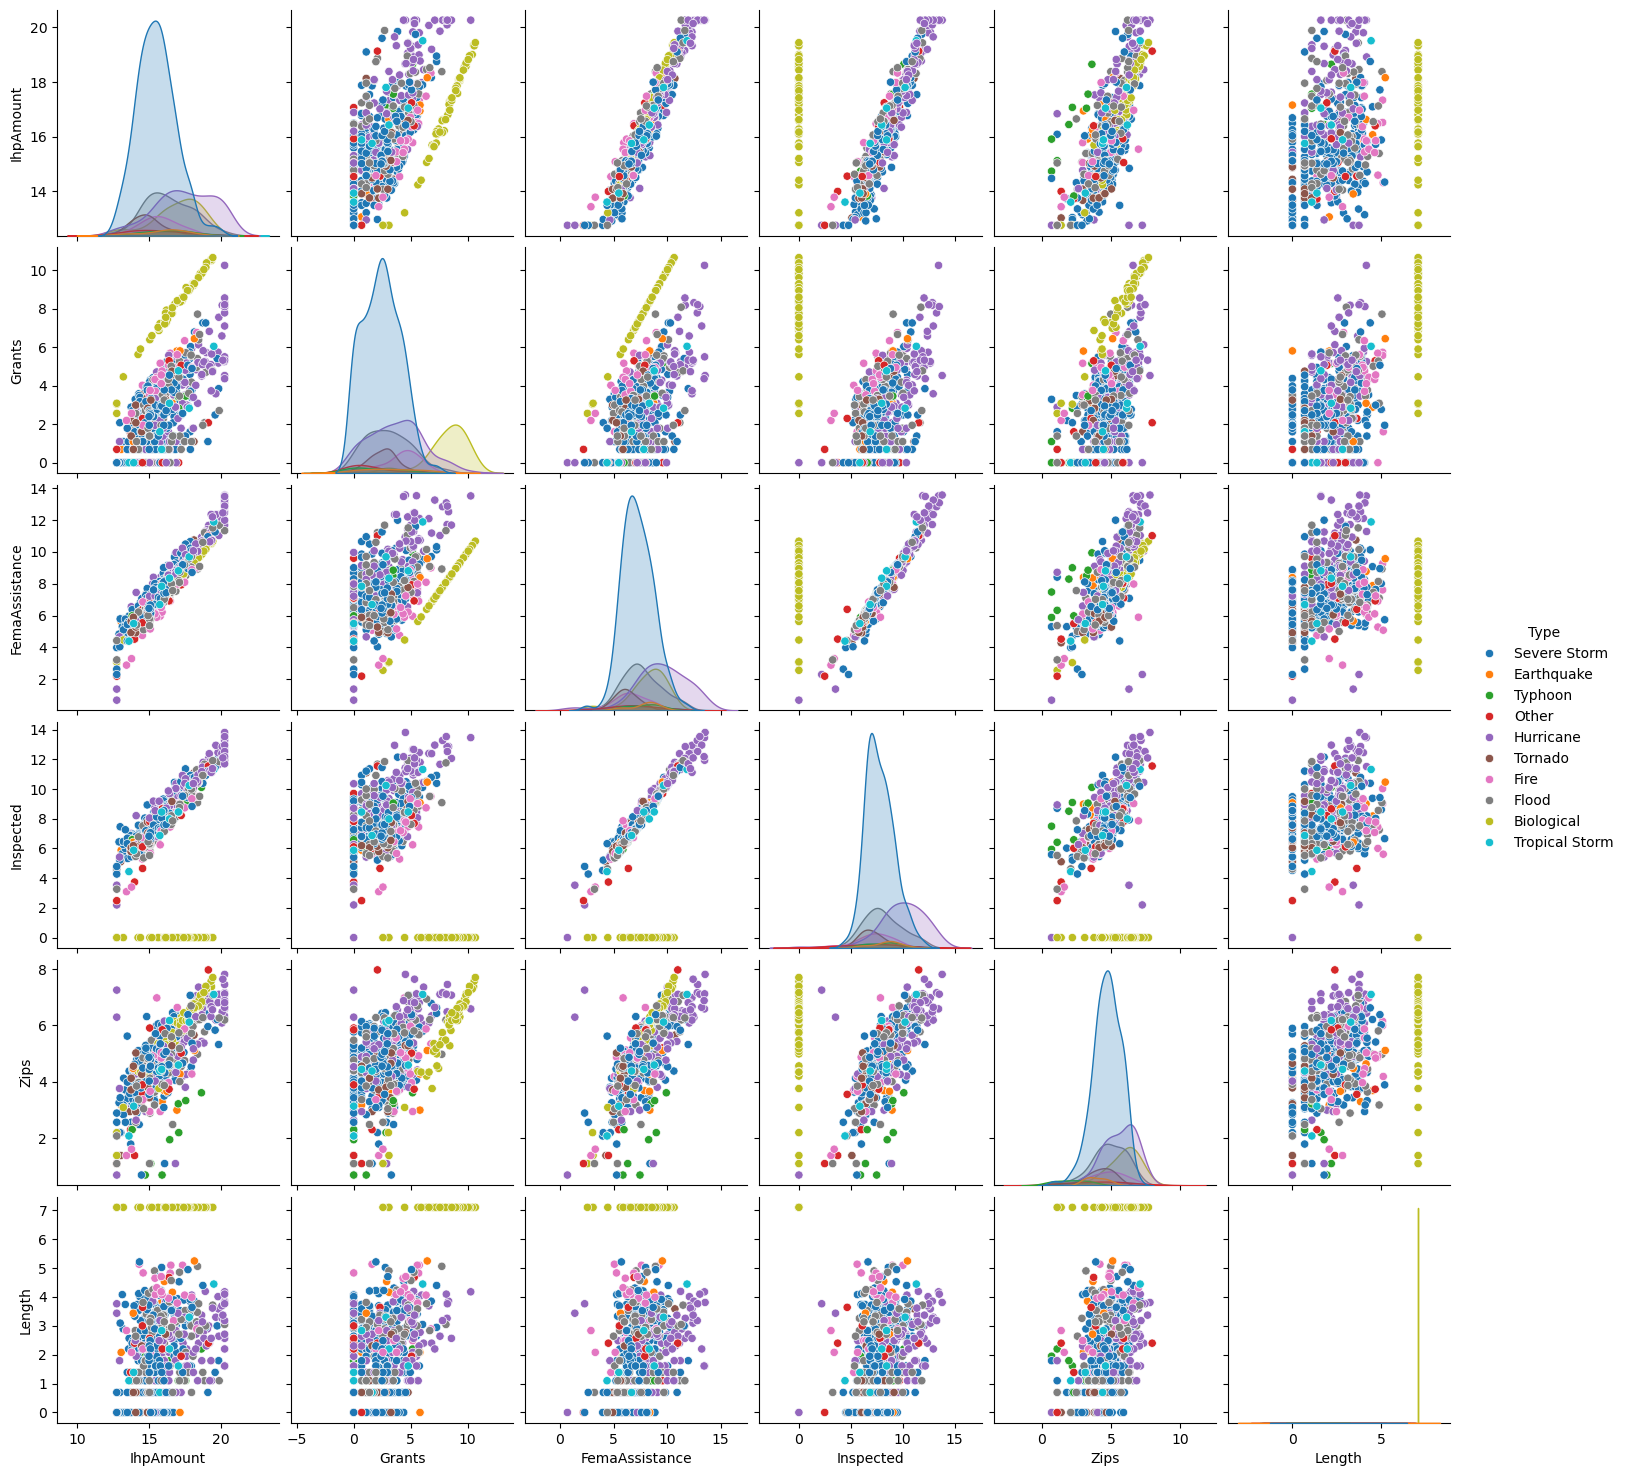

In [15]:
sns.pairplot(logamt, vars = ['IhpAmount','Grants','FemaAssistance','Inspected','Zips','Length'], hue='Type')
plt.show()

In [16]:
logamt = pd.get_dummies(logamt, columns=['Type'])

In [17]:
print(logamt.columns)
print(logamt.isna().sum())
logamt.shape

Index(['IhpAmount', 'Grants', 'FemaAssistance', 'Inspected', 'Zips', 'Length',
       'Type_Biological', 'Type_Earthquake', 'Type_Fire', 'Type_Flood',
       'Type_Hurricane', 'Type_Other', 'Type_Severe Storm', 'Type_Tornado',
       'Type_Tropical Storm', 'Type_Typhoon'],
      dtype='object')
IhpAmount              0
Grants                 0
FemaAssistance         0
Inspected              0
Zips                   0
Length                 0
Type_Biological        0
Type_Earthquake        0
Type_Fire              0
Type_Flood             0
Type_Hurricane         0
Type_Other             0
Type_Severe Storm      0
Type_Tornado           0
Type_Tropical Storm    0
Type_Typhoon           0
dtype: int64


(580, 16)

In [18]:
def print_performance_summary(model_name, y_true, y_pred):
    print(f"\n{model_name} Performance Summary")
    print("-" * 50)
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")

In [19]:
def plot_actual_predicted(y_test, y_predict):
    # Plot Actual vs. Predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_predict, color='blue', label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()
    
    # Residual Analysis
    residuals = y_test - y_predict
    plt.figure(figsize=(10, 6))
    plt.scatter(y_predict, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Error')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.ylim(-5, 5) 
    
    plt.title('Residual Plot')
    plt.legend()
    plt.show()

In [20]:
import joblib
def save_model(model, name):
    joblib.dump(model, name)

In [21]:
from sklearn.model_selection import train_test_split
# Early prediction
X = logamt[['Zips'] + [col for col in logamt.columns if 'Type_' in col]]
y = logamt['IhpAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# post disaster prediction
y2 = logamt['IhpAmount']
X2 = logamt.drop(columns='IhpAmount')

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# linear Regression 


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)

y2_predict = model2.predict(X2_test)


Linear Regression Model 1 Performance Summary
--------------------------------------------------
R² Score: 0.7438
MAE: 0.7568


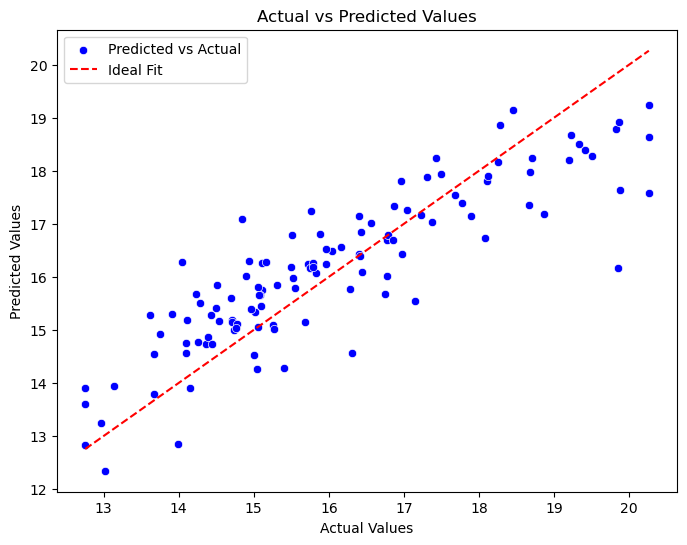

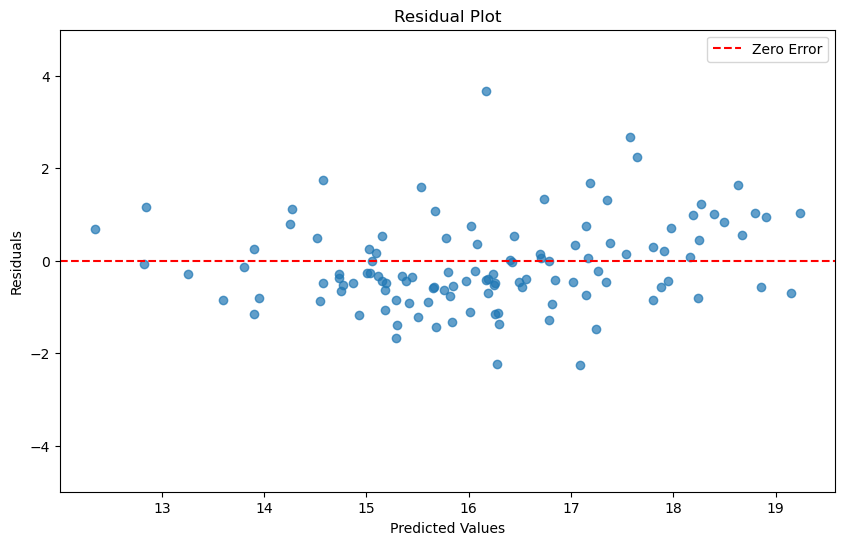


Linear Regression Model 2 Performance Summary
--------------------------------------------------
R² Score: 0.9721
MAE: 0.2317


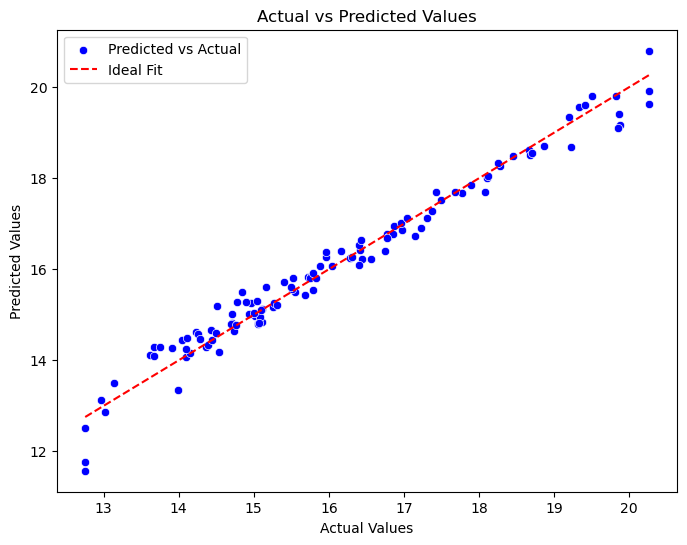

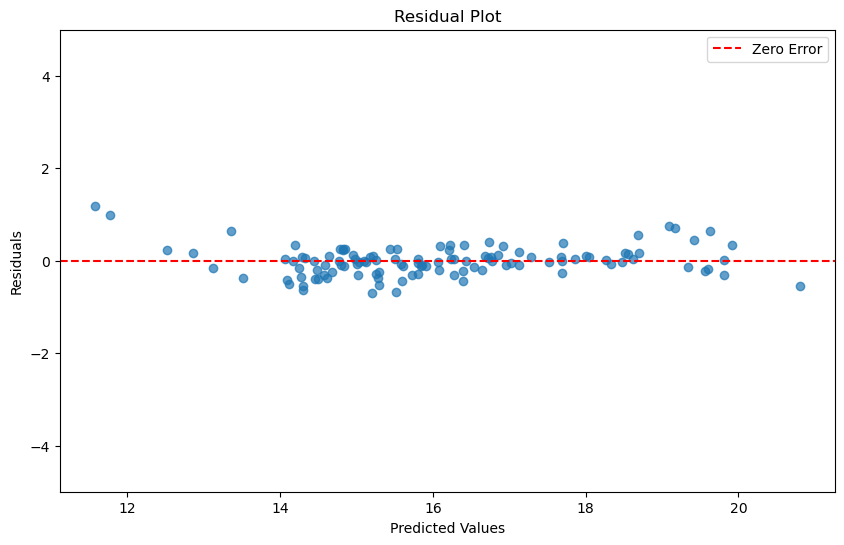

In [23]:
# Print performance summaries
print_performance_summary("Linear Regression Model 1", y_test, y_predict)
plot_actual_predicted( y_test, y_predict)

print_performance_summary("Linear Regression Model 2", y2_test, y2_predict)
plot_actual_predicted( y2_test, y2_predict)


In [24]:
save_model(model, 'linear_model_pre-disaster.pkl')
save_model(model2, 'linear_model_post-disaster.pkl')


# Gradient Boosting Regressor model

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

gbr_param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': range(3, 20, 2),
    'learning_rate': [0.001 ,0.01, 0.1, 0.2]
}
gbr_model = GradientBoostingRegressor()

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

gbr_grid_search = GridSearchCV(
    estimator=gbr_model,
    param_grid=gbr_param_grid,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

gbr_grid_search.fit(X_train, y_train)
gbr_best_params = gbr_grid_search.best_params_

print("best parameter: ", gbr_best_params)
print("best R-squared: ", gbr_grid_search.best_score_)

best parameter:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
best R-squared:  0.5606054980770672


In [27]:
best_gbr_model = GradientBoostingRegressor(**gbr_best_params)
best_gbr_model.fit(X_train, y_train)

cv_scores = cross_val_score(best_gbr_model, X, y, cv=kf, scoring='r2')
print(" R-squared Cross-Validation:", cv_scores)
print(" R-squared  Cross-Validation:", cv_scores.mean())

 R-squared Cross-Validation: [0.71497441 0.68127596 0.45563404 0.54823112 0.60776593]
 R-squared  Cross-Validation: 0.60157629185479


In [28]:
gbr_grid_search2 = GridSearchCV(
    estimator=gbr_model,
    param_grid=gbr_param_grid,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

gbr_grid_search2.fit(X2_train, y2_train)
gbr_best_params2 = gbr_grid_search2.best_params_

print("best parameter: ", gbr_best_params2)
print("best R-squared: ", gbr_grid_search2.best_score_)

best parameter:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
best R-squared:  0.9544195404883341


In [29]:
best_gbr_model2 = GradientBoostingRegressor(**gbr_best_params2)
best_gbr_model2.fit(X2_train, y2_train)

cv_scores = cross_val_score(best_gbr_model2, X2, y2, cv=kf, scoring='r2')
print(" R-squared Cross-Validation:", cv_scores)
print(" R-squared  Cross-Validation:", cv_scores.mean())

 R-squared Cross-Validation: [0.97363264 0.96846709 0.95284577 0.95693043 0.95692999]
 R-squared  Cross-Validation: 0.9617611842282854


In [30]:
y_predict = best_gbr_model.predict(X_test)
y2_predict = best_gbr_model2.predict(X2_test)


Gradient Boosting Regressor model 1 Performance Summary
--------------------------------------------------
R² Score: 0.7150
MAE: 0.7603


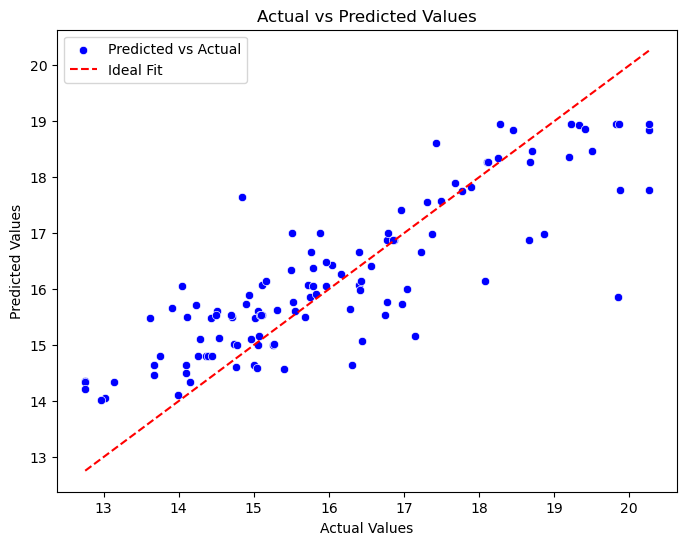

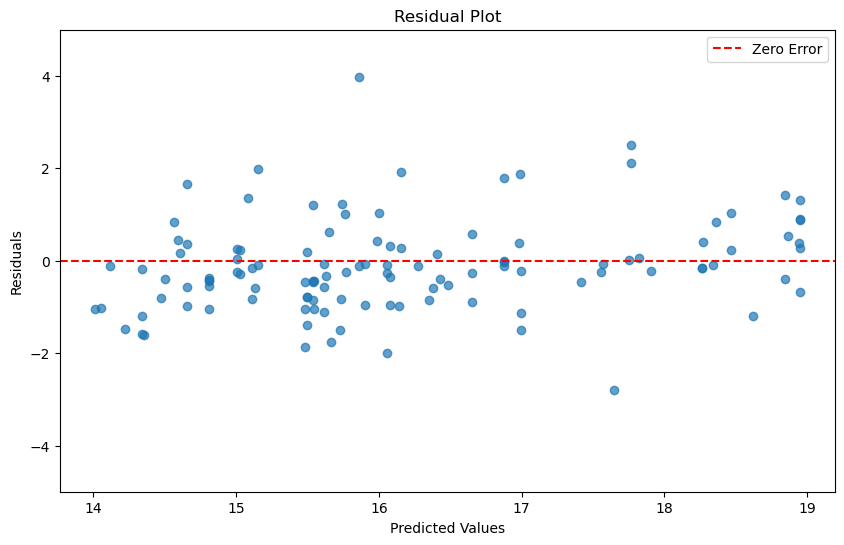


Gradient Boosting Regressor model 2 Performance Summary
--------------------------------------------------
R² Score: 0.9730
MAE: 0.2275


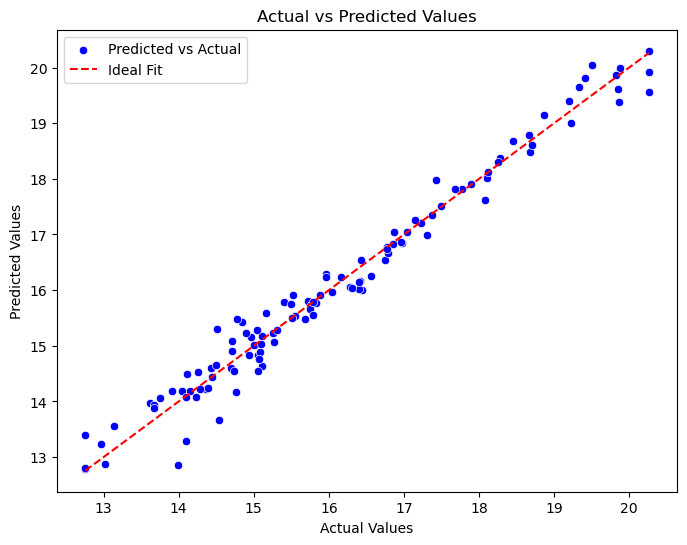

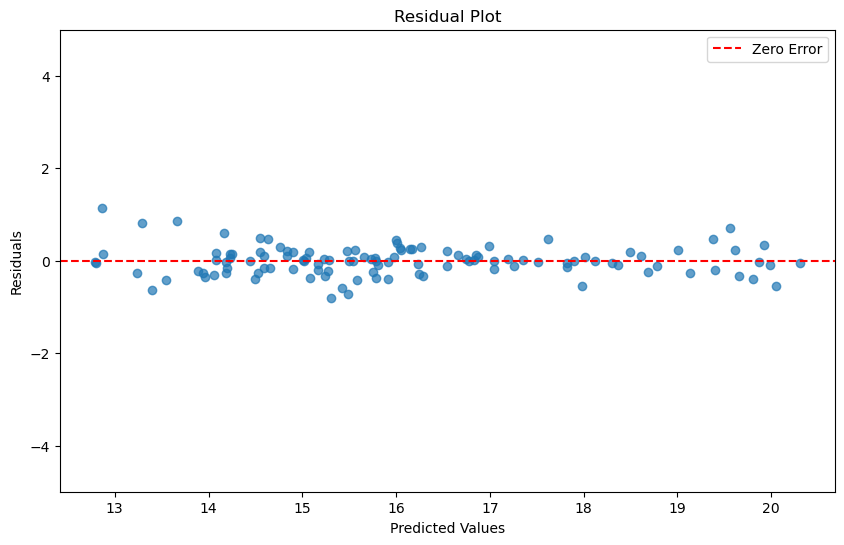

In [31]:
# Print performance summaries
print_performance_summary("Gradient Boosting Regressor model 1", y_test, y_predict)
plot_actual_predicted( y_test, y_predict)

print_performance_summary("Gradient Boosting Regressor model 2", y2_test, y2_predict)
plot_actual_predicted( y2_test, y2_predict)


In [32]:
save_model(best_gbr_model, 'GBR_model_pre-disaster.pkl')
save_model(best_gbr_model2, 'GBR_model_post-disaster.pkl')

# Random Forest Regressor 

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [34]:
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)
rf_best_params = rf_grid_search.best_params_

print("best_params: ", rf_best_params)
print("best R-squared: ", rf_grid_search.best_score_)

best_params:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
best R-squared:  0.5464468563443778


In [35]:
best_rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

cv_scores = cross_val_score(best_rf_model, X, y, cv=kf, scoring='r2')
print(" R-squared Cross-Validation:", cv_scores)
print(" R-squared  Cross-Validation:", cv_scores.mean())

 R-squared Cross-Validation: [0.72256081 0.68921371 0.40924497 0.51592014 0.59414109]
 R-squared  Cross-Validation: 0.5862161436959871


In [36]:
rf_grid_search2 = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

rf_grid_search2.fit(X2_train, y2_train)
rf_best_params2 = rf_grid_search2.best_params_

print("best_params: ", rf_best_params2)
print("best R-squared: ", rf_grid_search2.best_score_)

best_params:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
best R-squared:  0.9528289715912042


In [37]:
best_rf_model2 = RandomForestRegressor(**rf_best_params2, random_state=42)
best_rf_model2.fit(X2_train, y2_train)

cv_scores = cross_val_score(best_rf_model2, X2, y2, cv=kf, scoring='r2')
print(" R-squared Cross-Validation:", cv_scores)
print(" R-squared  Cross-Validation:", cv_scores.mean())

 R-squared Cross-Validation: [0.97196429 0.9664812  0.95469287 0.9515089  0.94595399]
 R-squared  Cross-Validation: 0.9581202492491633


In [38]:
y_predict = best_rf_model.predict(X_test)
y2_predict = best_rf_model2.predict(X2_test)


Random Forest Regressor model 1 Performance Summary
--------------------------------------------------
R² Score: 0.7191
MAE: 0.7535


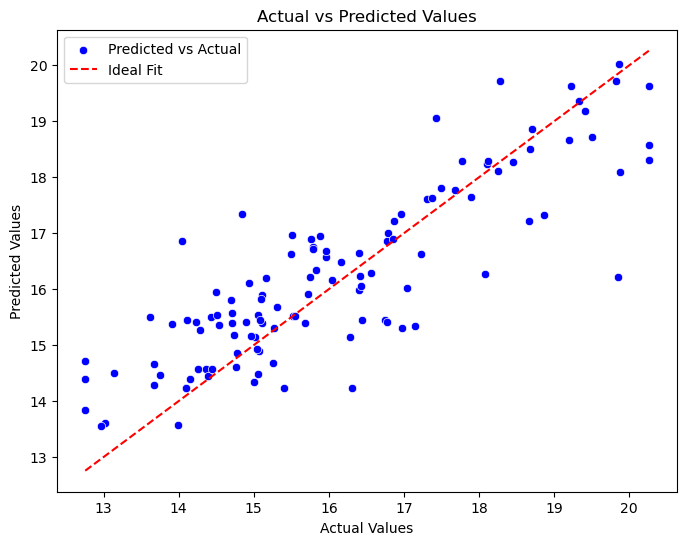

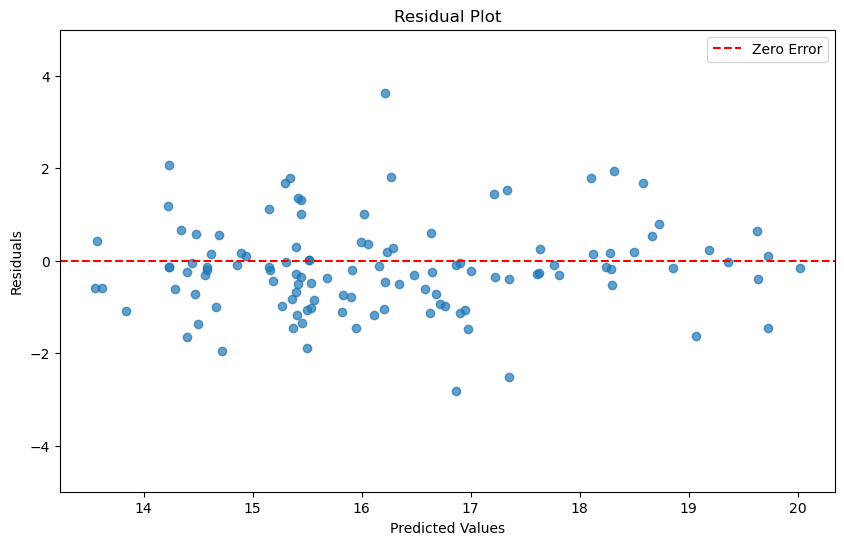


 Random Forest Regressor model 2 Performance Summary
--------------------------------------------------
R² Score: 0.9716
MAE: 0.2407


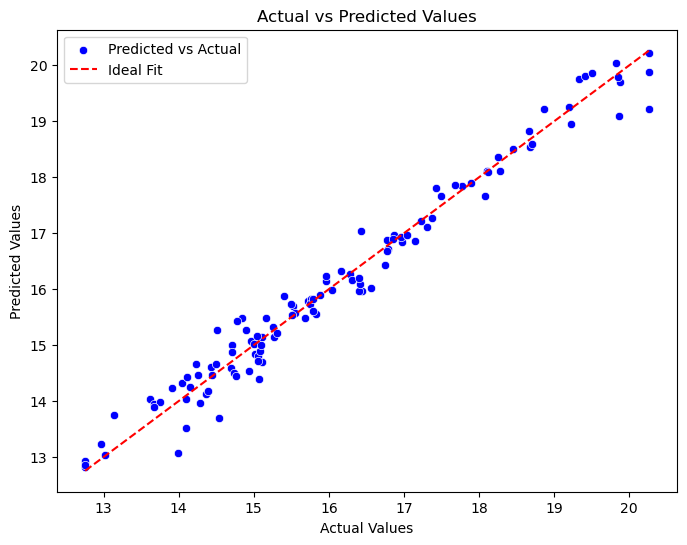

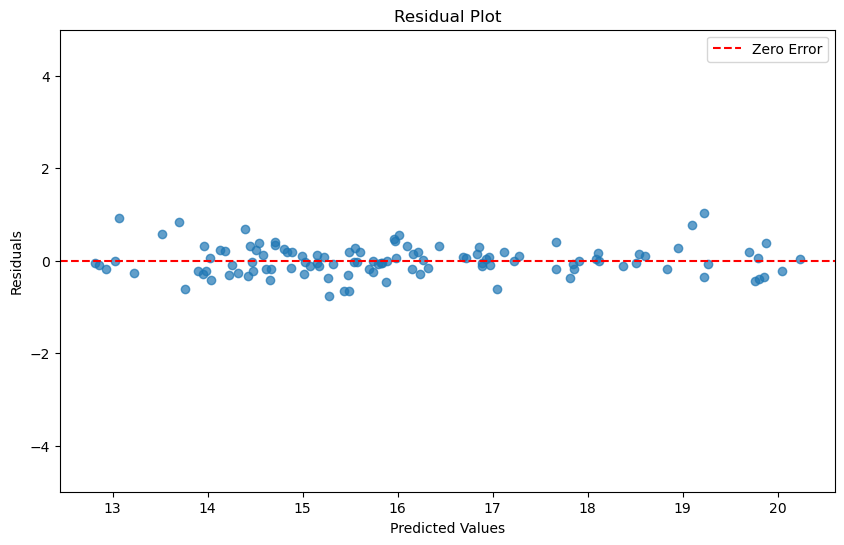

In [39]:
# Print performance summaries
print_performance_summary("Random Forest Regressor model 1", y_test, y_predict)
plot_actual_predicted( y_test, y_predict)

print_performance_summary(" Random Forest Regressor model 2", y2_test, y2_predict)
plot_actual_predicted( y2_test, y2_predict)


In [40]:
save_model(best_rf_model, "RF_model_pre-disaster.pkl")
save_model(best_rf_model2, "RF_model_post-disaster.pkl")

# SVR

In [41]:
from sklearn.svm import SVR

svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'poly' ,'rbf']
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
svr = SVR()

In [42]:
svr_grid_search = GridSearchCV(estimator=svr, param_grid=svr_param_grid, cv=kf, scoring='r2', n_jobs=-1)
svr_grid_search.fit(X_train, y_train)

print("SVR best parameter:", svr_grid_search.best_params_)
print("SVR R-squared:", svr_grid_search.best_score_)

SVR best parameter: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}
SVR R-squared: 0.5913120426869456


In [43]:
svr_grid_search2 = GridSearchCV(estimator=svr, param_grid=svr_param_grid, cv=kf, scoring='r2', n_jobs=-1)
svr_grid_search2.fit(X2_train, y2_train)

print("SVR best parameter:", svr_grid_search2.best_params_)
print("SVR R-squared:", svr_grid_search2.best_score_)

SVR best parameter: {'C': 100, 'epsilon': 0.2, 'kernel': 'rbf'}
SVR R-squared: 0.9668622858417338


In [44]:
best_svr = svr_grid_search.best_estimator_
y_predict = best_svr.predict(X_test)

best_svr2 = svr_grid_search2.best_estimator_
y2_predict = best_svr2.predict(X2_test)


SVR model 1 Performance Summary
--------------------------------------------------
R² Score: 0.7632
MAE: 0.6861


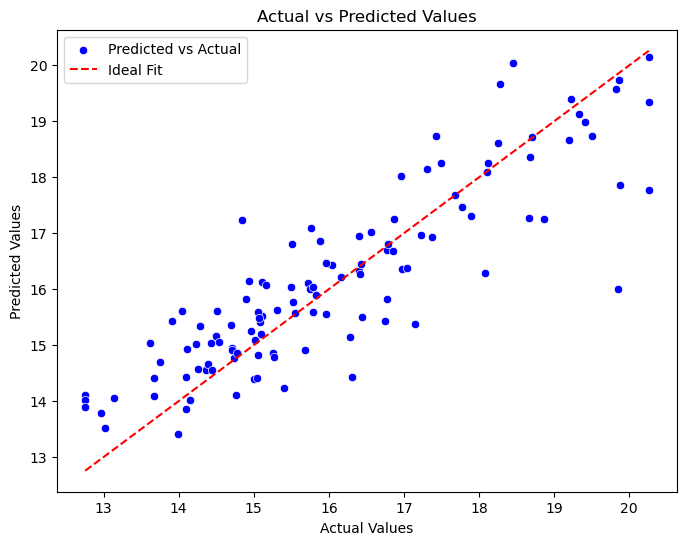

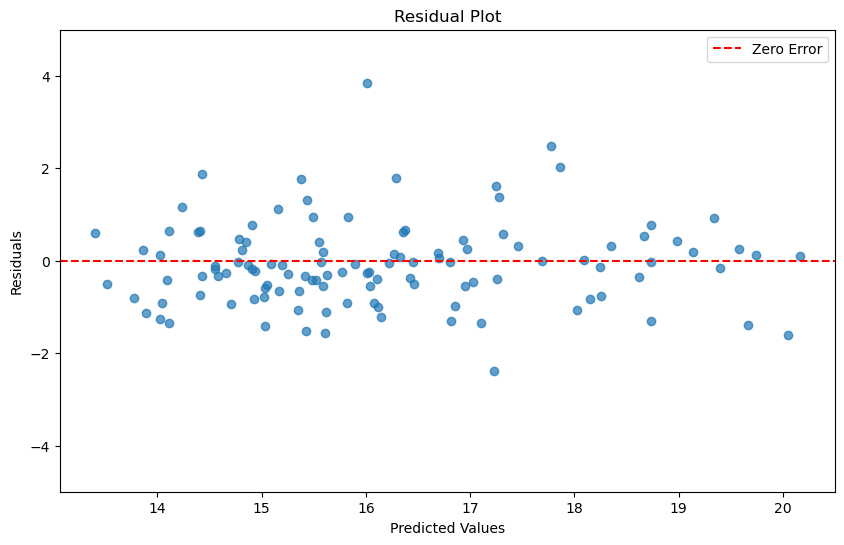


 SVR model 2 Performance Summary
--------------------------------------------------
R² Score: 0.9726
MAE: 0.2246


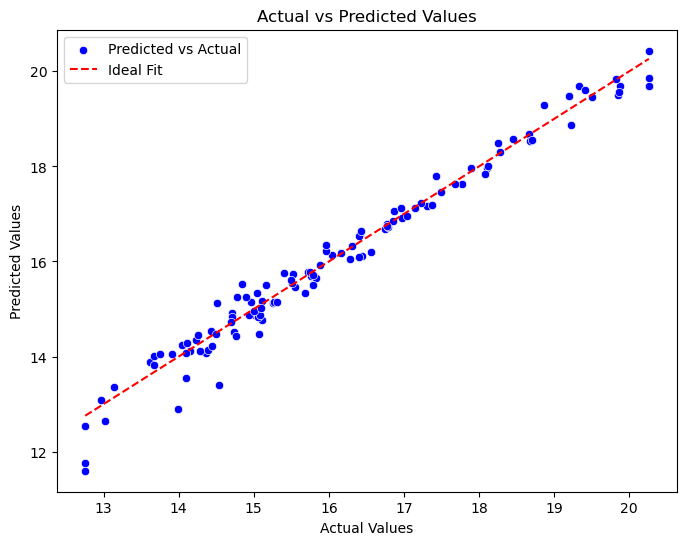

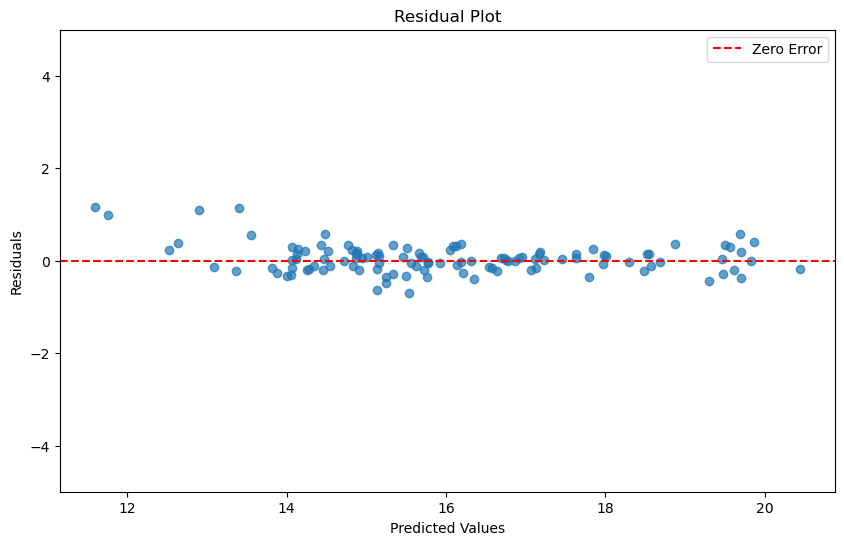

In [45]:
# Print performance summaries
print_performance_summary("SVR model 1", y_test, y_predict)
plot_actual_predicted( y_test, y_predict)

print_performance_summary(" SVR model 2", y2_test, y2_predict)
plot_actual_predicted( y2_test, y2_predict)


In [46]:
save_model(best_svr, "SVC_model_pre-disaster.pkl")
save_model(best_svr2, "SVC_model_post-disaster.pkl")

In [47]:
def compare_models(models_dict, X_test, y_test):
    results = {}
    for name, model in models_dict.items():
        predictions = model.predict(X_test)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        results[name] = {'R2': r2, 'MAE': mae}
    
    return pd.DataFrame(results).T

def plot_model_comparison(results_df):
    plt.figure(figsize=(12, 6))
    results_df['R2'].plot(kind='bar')
    plt.title('Model R² Score Comparison')
    plt.ylabel('R² Score')
    plt.ylim(0.5, 1) 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Pre-disaster Models Comparison:
                         R2       MAE
Linear Regression  0.743808  0.756751
Gradient Boosting  0.715023  0.760259
Random Forest      0.719116  0.753493
SVR                0.763233  0.686104


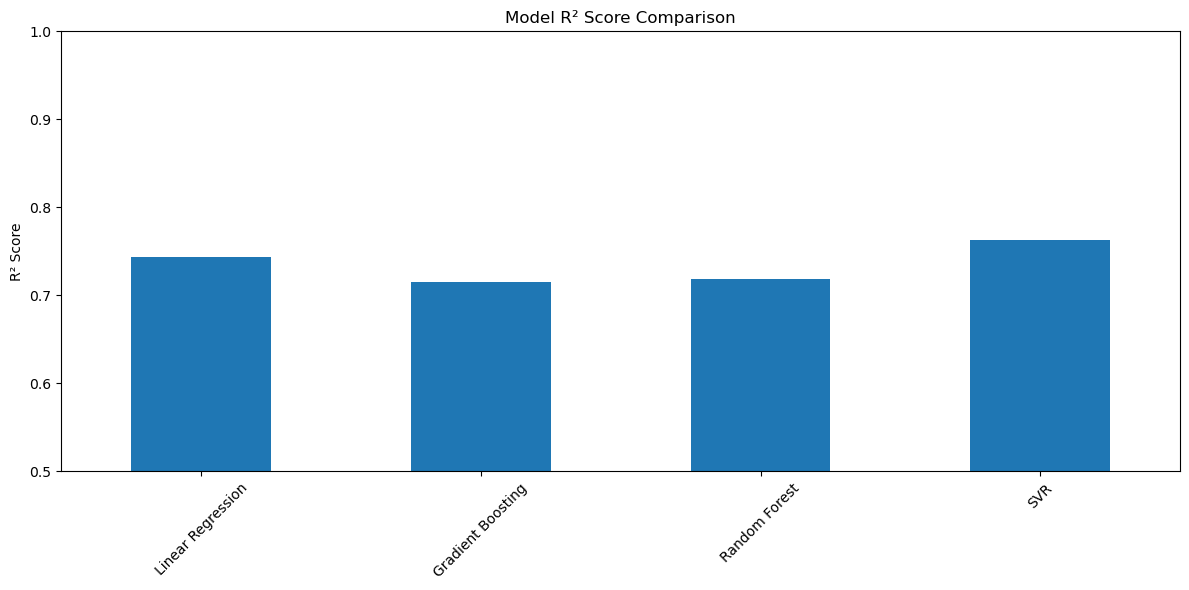


Post-disaster Models Comparison:
                         R2       MAE
Linear Regression  0.972064  0.231688
Gradient Boosting  0.973010  0.227486
Random Forest      0.971607  0.240666
SVR                0.972609  0.224575


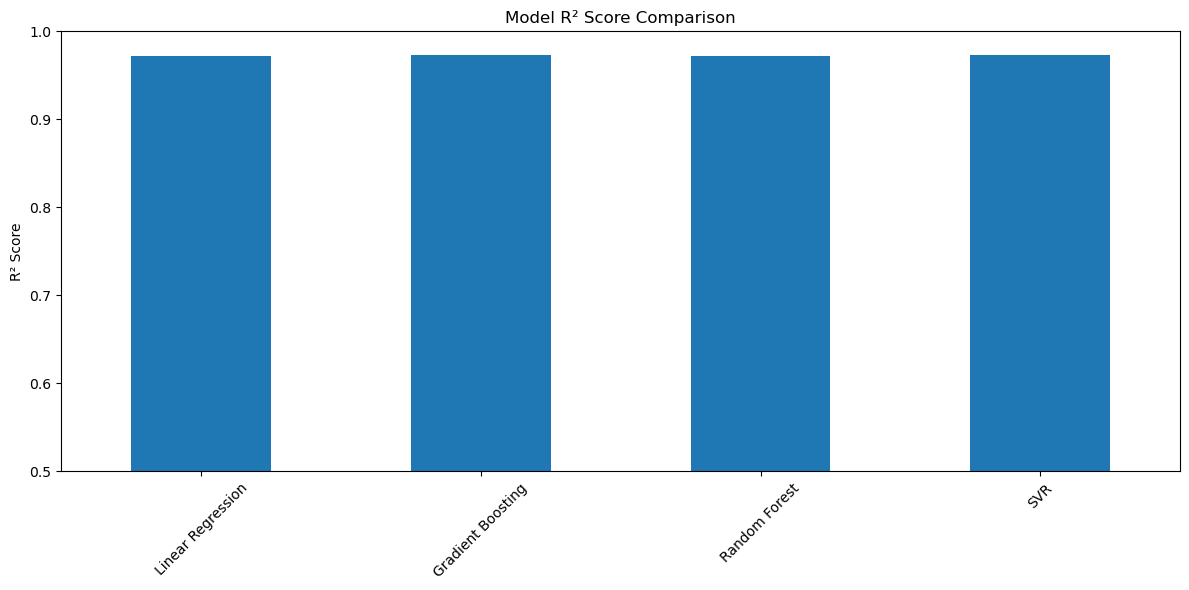

In [48]:
# Create dictionaries of models for both scenarios
models_pre_disaster = {
    'Linear Regression': model,
    'Gradient Boosting': best_gbr_model,
    'Random Forest': best_rf_model,
    'SVR': best_svr
}

models_post_disaster = {
    'Linear Regression': model2,
    'Gradient Boosting': best_gbr_model2,
    'Random Forest': best_rf_model2,
    'SVR': best_svr2
}

# Compare pre-disaster models
print("Pre-disaster Models Comparison:")
pre_disaster_results = compare_models(models_pre_disaster, X_test, y_test)
print(pre_disaster_results)
plot_model_comparison(pre_disaster_results)

# Compare post-disaster models
print("\nPost-disaster Models Comparison:")
post_disaster_results = compare_models(models_post_disaster, X2_test, y2_test)
print(post_disaster_results)
plot_model_comparison(post_disaster_results)

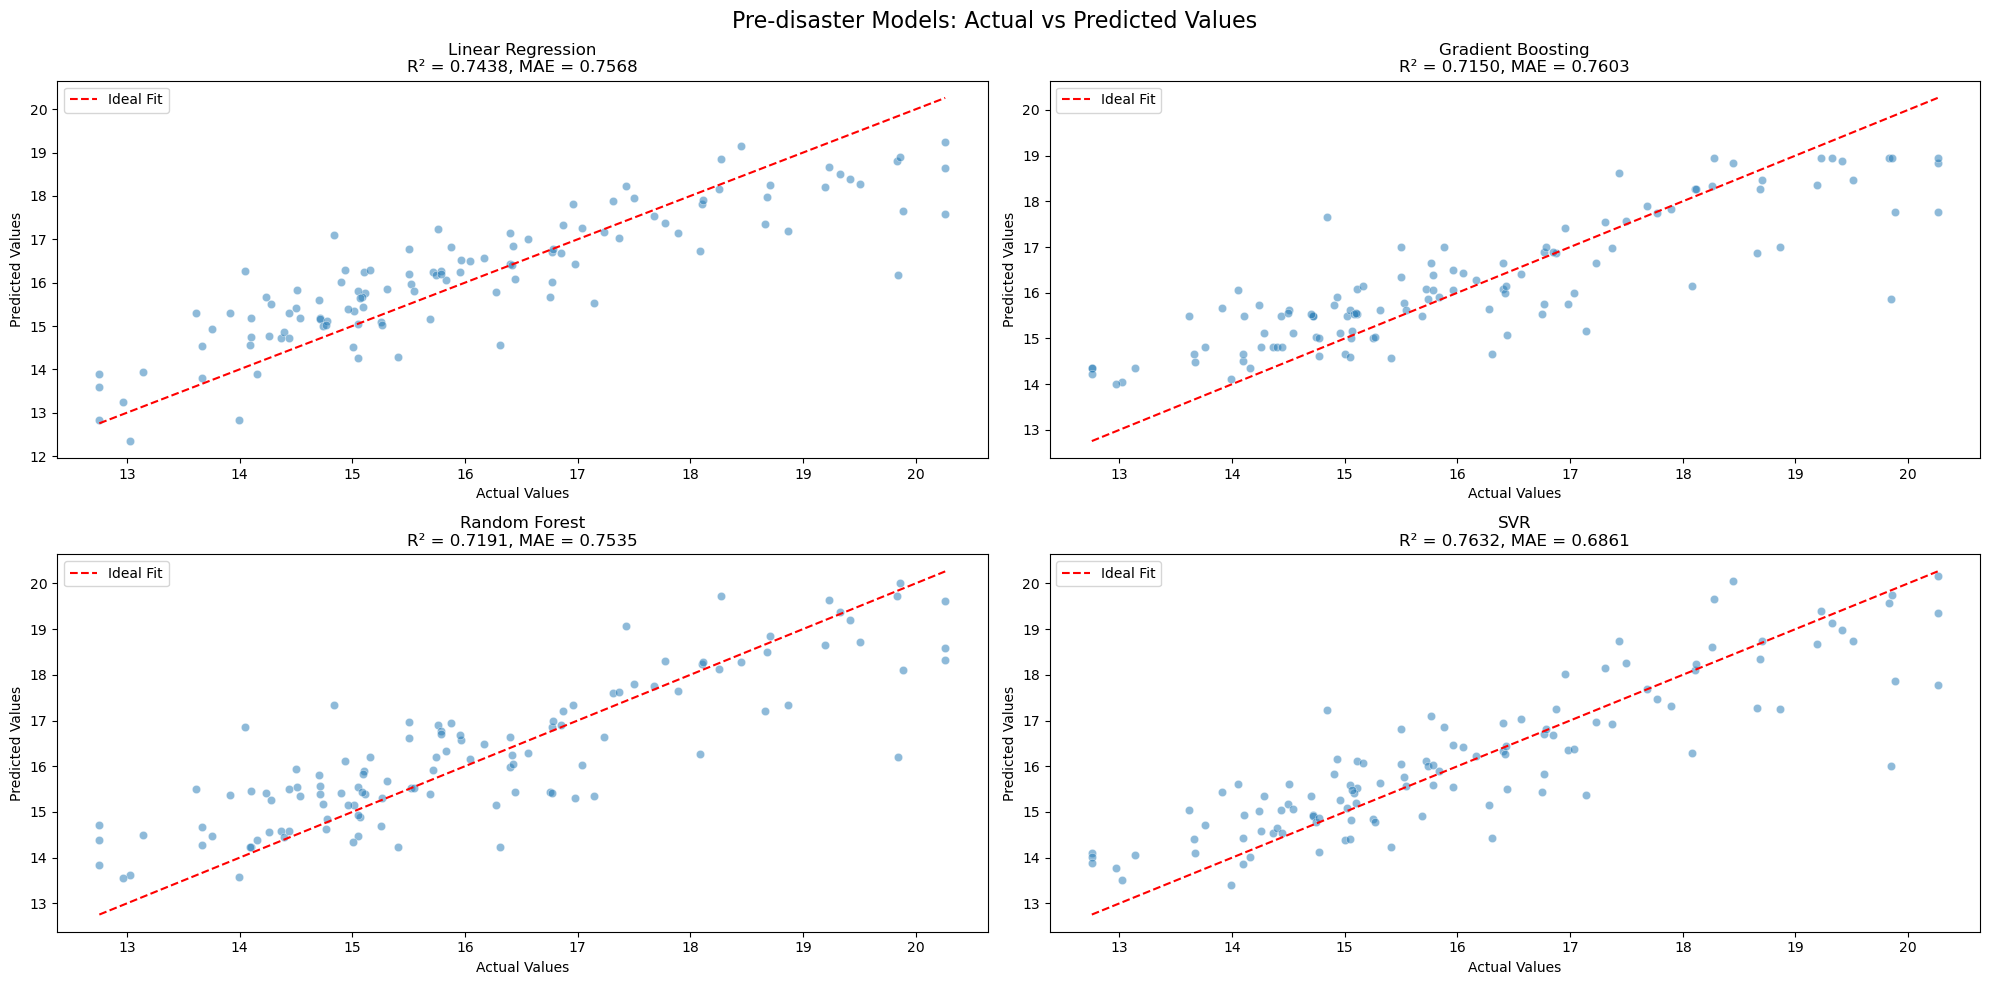

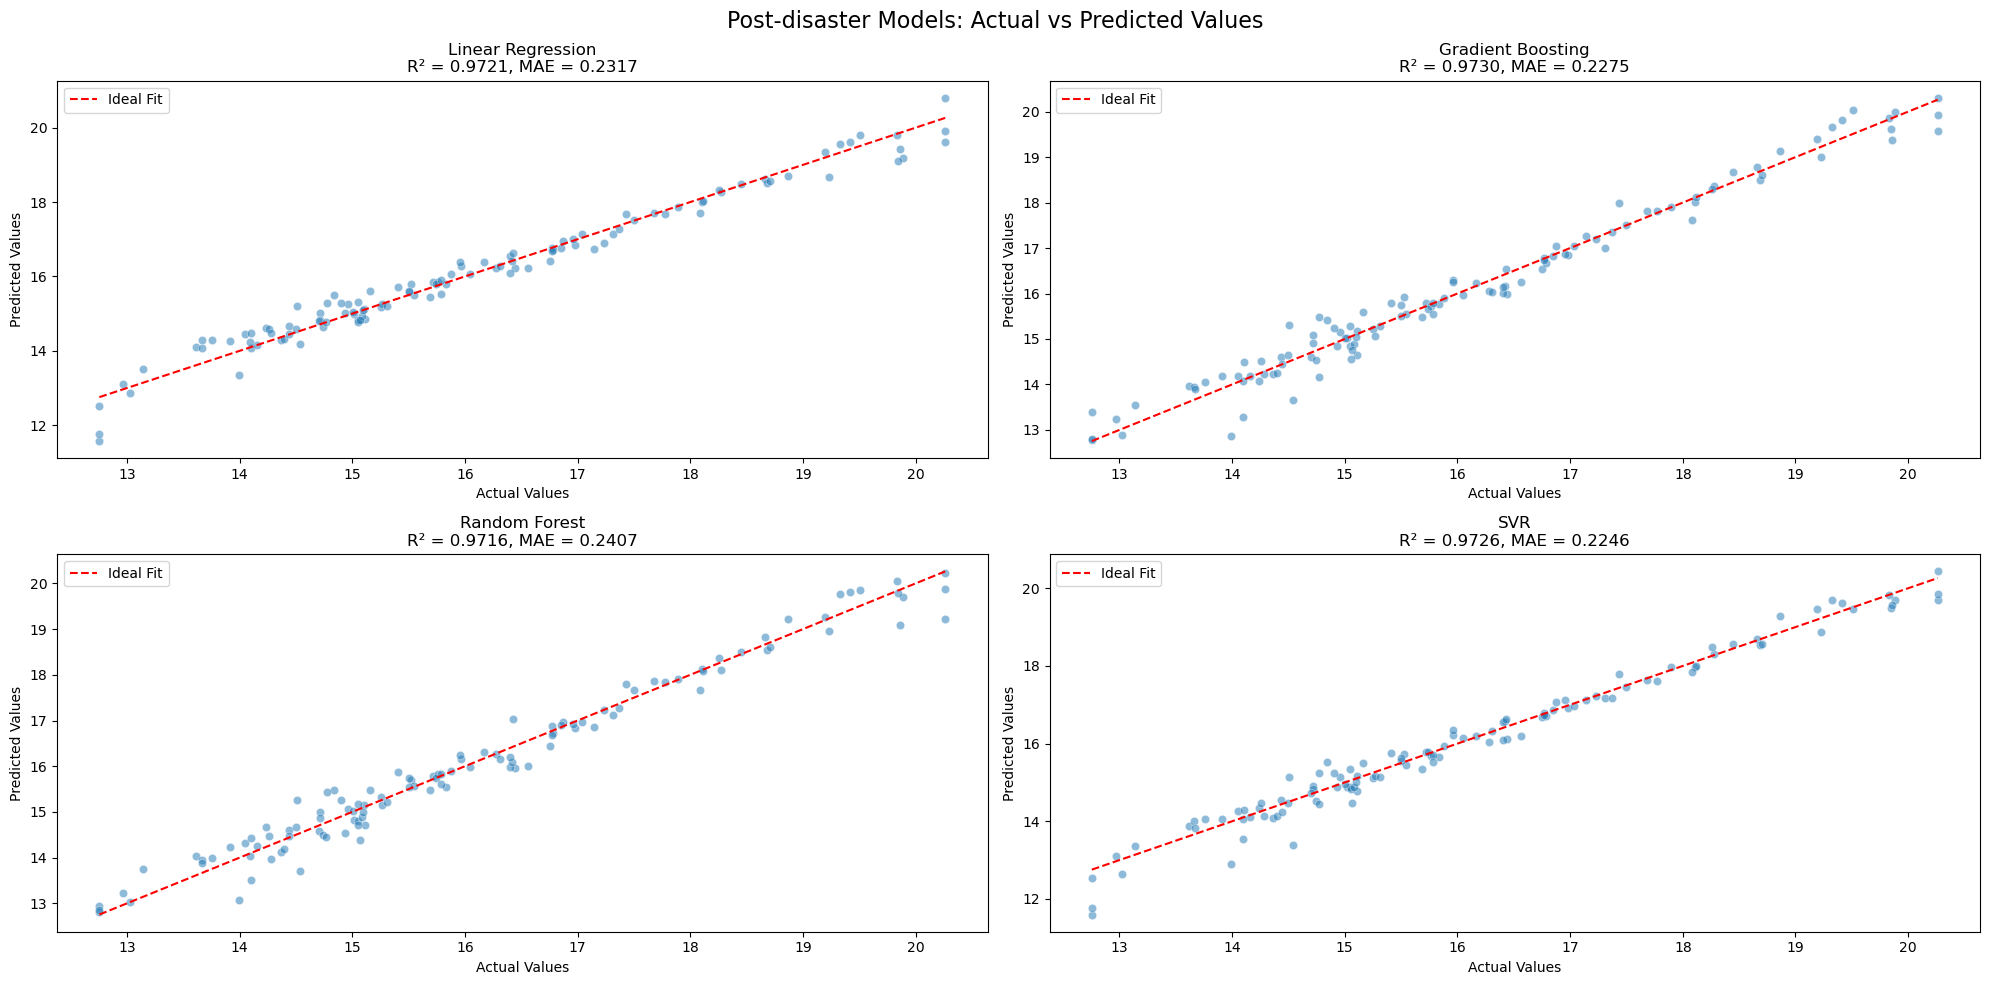

In [49]:
def plot_combined_predictions(models_dict, X_test, y_test, scenario="Pre-disaster"):
    plt.figure(figsize=(20, 10))
    
    # Create subplots for each model
    for i, (name, model) in enumerate(models_dict.items(), 1):
        plt.subplot(2, 2, i)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Scatter plot
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
        
        # Add ideal fit line
        plt.plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', label='Ideal Fit')
        
        # Calculate R² score
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        plt.title(f'{name}\nR² = {r2:.4f}, MAE = {mae:.4f}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
    
    plt.suptitle(f'{scenario} Models: Actual vs Predicted Values', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot pre-disaster models
plot_combined_predictions(models_pre_disaster, X_test, y_test, "Pre-disaster")

# Plot post-disaster models
plot_combined_predictions(models_post_disaster, X2_test, y2_test, "Post-disaster")